In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# @Time    : 2022/9/26 22:24
# @Author  : Wang Yujia
# @File    : GT_asc_symmetry_gen.ipynb
# @Description : 根据../cal_np_asc_symmetry_demo.ipynb，计算ascending-price auction的data。ref：信息不对称的paper里symmetry的情况。

# 0. what for
1. 在`../cal_np_asc_symmetry_demo.ipynb`上实验过的思路，现在automatically执行一下，输入所有的auction setting，得到相应的输出
2. **Steps**：
    - collect GT计算需要的features: `features_GT`，记得给target data留一个flag:`unique_setting`
        - features_GT = ['product_id','bidincrement','bidfee','retail']
        - unique_setting = ['product_id', 'bidincrement', 'bidfee','retail']
        - note：对于GT来说可能会出现不同的商品对应同样的retail，需要把他们当做不同的商品处理
    - 根据`features_GT`计算GT预测的结果`n`和`p`

# 1. Preparations
## 1.1 全局设置

In [3]:
# 经过threshold==16 filter之后，得到的dataset
data_selected_path = "../data/info_asymm/datawithnp_asc_symmetry_selected.csv"

# output path
data_path_root = "../data/info_asymm/results/asc_symmetry/"
filename_head = "GT_asc_symmetry_"
filename_tail = ".csv"

# GT计算需要的features
features_GT = ['product_id','bidincrement','bidfee','retail']
# 存在'product_id'相同但是'retail'不同的情况！
unique_setting = ['product_id', 'bidincrement', 'bidfee','retail']

import numpy as np
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator # 用于设置刻度间隔

## 1.2 读取data

In [4]:
data = pd.read_csv(data_selected_path, encoding="utf-8")

# 2. GT_model: ascending-price auction model in symmetry situation
## 2.1 提取GT计算需要的features和data

In [5]:
# 2.1.1 extract data
data_for_GT = data[features_GT].copy()
data_for_GT = data_for_GT.drop_duplicates().copy()
print("For symmetry GT model in ascending auctions, there are *{}* settings waiting to be inferred.".format(data_for_GT.shape[0]))

# 2.1.2 设置
b = np.array(data_for_GT.bidfee*0.01)          # bid fee (cent to dollar)
s = np.array(data_for_GT.bidincrement*0.01)    # bid increment (cent to dollar)
v = np.array(data_for_GT.retail)               # valuation
# 需要计算`A`组结果
A = data_for_GT.shape[0]

# 2.1.3 得到Key的函数
def get_key_from_index(i):
    key_i = list(data_for_GT[unique_setting].iloc[i,:])   # 取出key/ uniq features
    # make sure key_i_str is tuple which is hashable
    key_i_str = (str(key_i[0]),str(key_i[1]),str(key_i[2]),str(key_i[3]))
    return key_i_str

For symmetry GT model in ascending auctions, there are *99* settings waiting to be inferred.


## 2.2 Q
1. For ascending-price, there is $n \leq Q $
2. Q的大小应该为`A*1`

In [6]:
Q = np.floor((v-b)/s)
Q = np.array(Q.astype('int'))
print("\nshape of Q: ",Q.shape)
print("The largest Q is *{0}*, and the smallest one is *{1}*".format(max(Q),min(Q)))
print("In average, Q is : ",Q.mean())


shape of Q:  (99,)
The largest Q is *58420*, and the smallest one is *152*
In average, Q is :  1757.7171717171718


## 2.3 U
1. `U`作为一个**dict**，它的key是`unique_setting`,每一个key对应一个大小为(Q+2)的list. 因此`U`的shape应该为：`A*(Q+2)`
2. 注意边界值：根据公式可知`U[key][0]`不存在，指定为1，方便后续`P`的计算
3. 对于某一个确定的setting，`U[key]`一共有`Q[key]`个有效数字，有效index从`1`开始，因此`U[key]`的长度is various depending on the `Q`
4. 因此`U[key][j]`表示在某一个setting下：
> The probability that somebody makes the jth bid (given that j − 1 previous bids have been made)

In [7]:
U = dict()

# for every uniq setting i
for i in range(0,A):
    # Get the key of i
    key_i = get_key_from_index(i)      # u[i][0]方便计算，统一设为1
    U[key_i] = np.array([1.0]*(Q[i]+2)) # 避免浅拷贝，请你这样写
    # for every period j in the auction with uniq setting i
    for j in range(1,Q[i]+2):
        U[key_i][j] = 1.0-b[i]/(v[i]-s[i]*(j-1))
    assert(U[key_i].shape[0] == (Q[i]+2))

print("U is Prepared Well")

U is Prepared Well


## 2.4 N
1. 容易获取N，在ascending-price下，它和Q直接相关

In [8]:
N = dict()

# for every uniq setting i
for i in range(0,A):
    key_i = get_key_from_index(i)              # Get the key of i
    N[key_i] = np.arange(0,Q[i]+1)
    assert(max(N[key_i]) == Q[i],"N[key_i]的最大值不是Q[i]")

print("N is Prepared Well.")

N is Prepared Well.


<>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<ipython-input-8-6c03b33c9a25>:7: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(max(N[key_i]) == Q[i],"N[key_i]的最大值不是Q[i]")


## 2.5 P
1. `P`作为一个**dict**，它的key是`unique_setting`,每一个key对应一个大小为(Q+2)的list. 因此`P`的shape应该为：`A*(Q+1)`
2. 对于某一个确定的setting，`P[key_i]`一共有`Q[i]`个有效数字，有效index从`0`开始，因此`P[key_i]`的长度is various depending on the `Q[i]`
3. `P[key_i]`和`U[key_i]`的有效长度都是`Q[i]+1`，只不过`U[key_i]`为了保持意义，下标从`1`开始

In [9]:
P = dict()

# for every uniq setting i
for i in range(0,A):
    key_i = get_key_from_index(i)              # Get the key of i
    # N_i = np.array(range(0,Q[i]+1))
    P[key_i] = np.array([0.0]*(Q[i]+1))
    tmp = np.array([0.0]*(Q[i]+2))
    tmp[0] = 1.0
    
    # for every period j in the auction with uniq setting i
    for j in range(0,(Q[i]+1)):
        tmp[j+1] = tmp[j]*U[key_i][j]
        P[key_i][j] = (1-U[key_i][j+1])*tmp[j+1]

    # assert(len(P[key_i]) == len(N[key_i]),"P should record all the durations record in N")
    print("The sum of P_{0} is: {1}".format(i,np.sum(P[key_i])))

print("\nP is Prepared Well.")

The sum of P_0 is: 0.9999999999807561
The sum of P_1 is: 0.9999999996754446
The sum of P_2 is: 0.9999999998946243
The sum of P_3 is: 0.9999999998946243
The sum of P_4 is: 0.9999999999967758
The sum of P_5 is: 0.9999999999967758
The sum of P_6 is: 0.9999999999967758
The sum of P_7 is: 0.9999999999967758
The sum of P_8 is: 0.9999999999995501
The sum of P_9 is: 0.9999999999967758
The sum of P_10 is: 0.9999999999945259
The sum of P_11 is: 0.9999999999999999
The sum of P_12 is: 0.9999999999999994
The sum of P_13 is: 0.9999999999968002
The sum of P_14 is: 0.9999999999968002
The sum of P_15 is: 0.9999999999999993
The sum of P_16 is: 0.9999999999958279
The sum of P_17 is: 0.9999999999999936
The sum of P_18 is: 0.9999999999995776
The sum of P_19 is: 0.999999999999999
The sum of P_20 is: 0.9999999999929461
The sum of P_21 is: 0.9999999999998995
The sum of P_22 is: 0.9999999999998537
The sum of P_23 is: 0.9999999999995002
The sum of P_24 is: 0.9999999999998593
The sum of P_25 is: 0.99999999999969

# 3. Dict Output
1. 每个unique setting对应着一组keys + 一个distrb
    - 输出3个csv文件，分别存储了`P,N,Keys`，前两者是dict直接输出
    - `P`的每一个item存储的是一个uniq setting以及对应的distrb.
    - `N`的每一个item存储的是一个uniq setting以及对应的duration array
    - `Keys`的每一个item存储的是一个uniq setting，一共存储了`A`个

In [10]:
filename_P = data_path_root+(filename_head + "P" + filename_tail)
filename_N = data_path_root+(filename_head + "N" + filename_tail)
filename_keys = data_path_root+(filename_head + "Keys" + filename_tail)

# P to csv
with open(filename_P,"w+",encoding='utf—8') as f:
    w=csv.writer(f)
    # 每行存储一个键值对
    w.writerow(P.items())

# N to csv
with open(filename_N,"w+",encoding='utf—8') as f:
    w=csv.writer(f)                  # 每行存储一个键值对
    w.writerow(N.items())

# Keys to csv
with open(filename_keys,"w+",encoding='utf—8',newline="") as f:
    w=csv.writer(f)
    # firstly write in the header
    w.writerow(unique_setting)
    # for every uniq setting i
    for i in range(0,A):
        key = get_key_from_index(i)
        w.writerow(key)

print("Output is DONE")

Output is DONE


# 4. Test and Plot
## 4.1 plot
1. 根据指定的index进行画图，

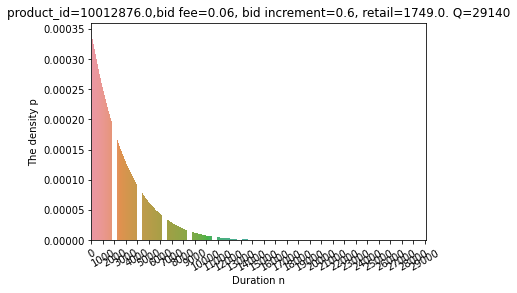

Plot is DONE


In [12]:
index_i = 28
key_i_forplot =  get_key_from_index(index_i)

plt.xlabel("Duration n")
plt.ylabel("The density p")
plt.title("product_id={0},bid fee={1}, bid increment={2}, retail={3}. Q={4}".format(key_i_forplot[0],float(key_i_forplot[1])*0.01,float(key_i_forplot[2])*0.01,key_i_forplot[3],Q[index_i]))

ax = sns.barplot(x = N[key_i_forplot],y=P[key_i_forplot])

# 设置刻度
plt.xticks(np.arange(0, Q[index_i], step=1000),rotation=30)

plt.show()
print("Plot is DONE")